In [60]:
! pip3 install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [61]:
import glob
import os
import boto3
import socket
from botocore.handlers import disable_signing
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

In [62]:
if socket.gethostname() == 'Rohits-MacBook-Pro.local':
    rootdir = '/Users/rohitchanne/Documents/capstone/data/data_parquet/'
else: 
    rootdir = '' # Enter your hone dir here

In [63]:
list_of_files = filter( os.path.isfile, glob.glob(rootdir + '*') )
files_with_size = [ file_path for file_path in list_of_files ]

dfs_parquet = {}
for file_path in files_with_size:
    if 'parquet' in file_path:
        file_name = file_path.split('/')[-1]
        df_name = file_name.split('_')[0]
        print(f'Reading Data File: {file_name}')       
        dfs_parquet[df_name] = pd.read_parquet(file_path, engine='pyarrow')

Reading Data File: Wednesday-21-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-23-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thuesday-20-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-22-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-16-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Wednesday-28-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Wednesday-14-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-15-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-01-03-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-02-03-2018_TrafficForML_CICFlowMeter_clean.parquet


In [64]:
# Dropping extra data for Thuesday-20-02-2018 file
dfs_parquet['Thuesday-20-02-2018'].drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1, inplace=True)

In [65]:
for k,df in dfs_parquet.items():
    print(k)
    df['is_allowed'] = df['Label'] == 'Benign'
    del df['Label']
    print(f'DF:{k}, Shape{df.shape}')

Wednesday-21-02-2018
DF:Wednesday-21-02-2018, Shape(1048575, 80)
Friday-23-02-2018
DF:Friday-23-02-2018, Shape(1048575, 80)
Thuesday-20-02-2018
DF:Thuesday-20-02-2018, Shape(7948748, 80)
Thursday-22-02-2018
DF:Thursday-22-02-2018, Shape(1048575, 80)
Friday-16-02-2018
DF:Friday-16-02-2018, Shape(1048574, 80)
Wednesday-28-02-2018
DF:Wednesday-28-02-2018, Shape(613071, 80)
Wednesday-14-02-2018
DF:Wednesday-14-02-2018, Shape(1048575, 80)
Thursday-15-02-2018
DF:Thursday-15-02-2018, Shape(1048575, 80)
Thursday-01-03-2018
DF:Thursday-01-03-2018, Shape(331100, 80)
Friday-02-03-2018
DF:Friday-02-03-2018, Shape(1048575, 80)


In [66]:
cat_cols = ['Dst Port']

In [67]:
def transformations(df_list):
    df_temp = pd.concat(df_list)
    df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'])
    df_temp['Date'] = pd.to_datetime(df_temp['Timestamp']).dt.date
    df_temp['TS_relative'] = (df_temp['Timestamp'].astype(int) - 
                             pd.to_datetime(df_temp['Date']).astype(int))/ 10**9
    df_temp = df_temp.drop(['Timestamp'], axis = 1)
    df_temp = df_temp.drop(['Date'], axis = 1)
    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_temp.fillna(0, inplace=True)
    df_temp[cat_cols] = df_temp[cat_cols].astype('category')
    X_temp = df_temp.drop(['is_allowed'], axis = 1)
    y_temp = df_temp['is_allowed']*1 
    
    return X_temp, y_temp

In [68]:
def scale_data(df):
    stdsc = MinMaxScaler()
    stdsc.fit(df)
    return stdsc.transform(df)

### Creating Train and Test Data sets

In [69]:
X_train, y_train = transformations([dfs_parquet['Friday-02-03-2018'], 
                      dfs_parquet['Friday-16-02-2018'], 
                      dfs_parquet['Friday-23-02-2018'],
                      dfs_parquet['Thursday-01-03-2018'],
                      dfs_parquet['Thursday-15-02-2018'],
                      dfs_parquet['Thursday-22-02-2018'],
                      dfs_parquet['Thuesday-20-02-2018'],
                      dfs_parquet['Wednesday-14-02-2018'],
                      dfs_parquet['Wednesday-21-02-2018']
                     ])

In [70]:
X_train_scaled = scale_data(X_train)
X_train.shape

(15619872, 79)

In [71]:
X_test, y_test = transformations([dfs_parquet['Wednesday-28-02-2018']])

In [72]:
X_test_scaled = scale_data(X_test)
X_test.shape

(613071, 79)

### Preparing data for Pytorch by converting Dataframes into Tensors

In [73]:
x_for_nn =  torch.from_numpy(X_train_scaled).float()
x_for_nn.shape

torch.Size([15619872, 79])

In [74]:
y_for_nn = torch.from_numpy(y_train.to_numpy())
y_for_nn.shape

torch.Size([15619872])

In [75]:
x_for_nn_test =  torch.from_numpy(X_test_scaled).float()
x_for_nn_test.shape

torch.Size([613071, 79])

In [76]:
y_for_nn_test = torch.from_numpy(y_test.to_numpy())
y_for_nn_test.shape

torch.Size([613071])

### Model Setup

- Layers:
1. Linear input=79 out=128
2. BayesLinear input=128 out=128
3. BayesLinear input=120 out=2 (Benign or Not Benign)

- Activation Function = ReLU

- Loss Function Hybrid:
 Cross Entropy and Kullback-Leibler Divergence (KL divergence)

- Optimizer = Adam with Learning Rate = 0.01

In [77]:
model = nn.Sequential(
    nn.Linear(in_features=79, out_features=128),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=128),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=2),
)

ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

optimizer = optim.Adam(model.parameters(), lr=0.01)

### Training with Batches

In [78]:
batch_size = 1048576
train_data = TensorDataset(x_for_nn, y_for_nn)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False)

In [79]:
avg_loss_list = []
avg_loss_list_by_iteration = []
F1_progression = []
Accuracy_progression  = []
Precision_progression  = []
Recall_progression  = []

In [86]:
kl_weight = 0.1
epochs = 3
for epoch in range(epochs):
    start_time = time.process_time()
    avg_loss = 0.
    counter = 0
    for x, y in train_loader:
        counter += 1
        pre = model(x)
        ce = ce_loss(pre, y)
        kl = kl_loss(model)
        cost = ce + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_loss += cost.item()
        if epoch%1 == 0:
            avg_loss_list.append(avg_loss)
            avg_loss_list_by_iteration.append(avg_loss/counter)
            print(f"Epoch {epoch}, Batch {counter}...... Average Loss for Epoch: {avg_loss/counter}")
            _, predicted = torch.max(pre.data, 1)
            F1_current = f1_score(y, predicted)
            F1_progression.append(F1_current)
            print(f'F1: {F1_current}')
            Accuracy_current = accuracy_score(y, predicted)
            Accuracy_progression.append(Accuracy_current)            
            print(f'Accuracy: {Accuracy_current}')
            Precision_current = precision_score(y, predicted)
            Precision_progression.append(Precision_current)            
            print(f'Precision: {Precision_current}')
            Recall_current = recall_score(y, predicted)
            Recall_progression.append(Recall_current)            
            print(f'Recall: {Recall_current}')            
    current_time = time.process_time()

Epoch 0, Batch 1...... Average Loss for Epoch: 0.18908730149269104
F1: 0.9420197204922925
Accuracy: 0.9085760116577148
Precision: 0.9923405480757713
Recall: 0.8965560512303928
Epoch 0, Batch 2...... Average Loss for Epoch: 0.16874141991138458
F1: 0.9715612474946356
Accuracy: 0.9520845413208008
Precision: 0.9553213538727319
Recall: 0.9883628264569787
Epoch 0, Batch 3...... Average Loss for Epoch: 0.1608350028594335
F1: 0.971186239284805
Accuracy: 0.9514350891113281
Precision: 0.9552193454030626
Recall: 0.9876959940338633
Epoch 0, Batch 4...... Average Loss for Epoch: 0.15668481960892677
F1: 0.9702968726004162
Accuracy: 0.9500131607055664
Precision: 0.9554115177426536
Recall: 0.9856533973160421
Epoch 0, Batch 5...... Average Loss for Epoch: 0.15830240845680238
F1: 0.964460404687447
Accuracy: 0.9390573501586914
Precision: 0.9330881221435819
Recall: 0.9980156811830407
Epoch 0, Batch 6...... Average Loss for Epoch: 0.16092833131551743
F1: 0.962491737717666
Accuracy: 0.9356002807617188
Preci

In [90]:
for i in range(10):
    
    pre_test = model(x_for_nn_test)
    _, predicted_test = torch.max(pre_test.data, 1)
    print(f'F1: {f1_score(y_for_nn_test, predicted_test)}')
    print(f'Accuracy: {accuracy_score(y_for_nn_test, predicted_test)}')
    print(f'Precision: {precision_score(y_for_nn_test, predicted_test)}')
    print(f'Recall: {recall_score(y_for_nn_test, predicted_test)}')

F1: 0.8579045506849003
Accuracy: 0.7558716690236531
Precision: 0.8874859553872384
Recall: 0.8302315325248071
F1: 0.856022038064364
Accuracy: 0.7531117929244737
Precision: 0.8873611637006185
Recall: 0.8268210216832047
F1: 0.8549215739510247
Accuracy: 0.7515932086169465
Precision: 0.887633403558747
Recall: 0.8245350973906652
F1: 0.8574414060459139
Accuracy: 0.755211060382892
Precision: 0.8875304565682945
Recall: 0.8293256155825064
F1: 0.8554037427960889
Accuracy: 0.7523223248204531
Precision: 0.8877617982147517
Recall: 0.825321572951121
F1: 0.8504390742587811
Accuracy: 0.745142079791737
Precision: 0.8875679822896395
Recall: 0.8162918044836457
F1: 0.8512211844738736
Accuracy: 0.7462202583387568
Precision: 0.8874163338630278
Recall: 0.8178629180448365
F1: 0.8530070748525316
Accuracy: 0.7488431193124451
Precision: 0.8876544019327933
Recall: 0.820962881293642
F1: 0.8584624465382604
Accuracy: 0.7567149644984023
Precision: 0.8876137922373041
Recall: 0.831165012862918
F1: 0.8509804109163099
Acc

In [88]:
avg_loss_list

[0.7444319128990173,
 1.2376908659934998,
 1.7558758854866028,
 2.2262187600135803,
 2.6879622042179108,
 3.1933408677577972,
 3.8632909953594208,
 4.329306989908218,
 4.855386644601822,
 5.293779730796814,
 5.754618138074875,
 6.189710170030594,
 6.6089809238910675,
 7.050123184919357,
 7.473445177078247,
 0.4325394034385681,
 0.8449037075042725,
 1.2463641166687012,
 1.6739814281463623,
 2.0830639600753784,
 2.467134326696396,
 2.8752513229846954,
 3.396102696657181,
 3.776685118675232,
 4.143112689256668,
 4.462935715913773,
 4.777033299207687,
 5.123895823955536,
 5.4361326694488525,
 5.8694173991680145,
 0.3001967966556549,
 0.6049785912036896,
 0.8747952580451965,
 1.1845465004444122,
 1.475635439157486,
 1.7246387749910355,
 1.9903404861688614,
 2.2405381947755814,
 2.524069681763649,
 2.790242627263069,
 3.0306201577186584,
 3.319510728120804,
 3.579116314649582,
 3.8346735537052155,
 4.069934546947479,
 0.3613051474094391,
 0.6351765692234039,
 0.8669359534978867,
 1.125050976

In [91]:
avg_loss_list_by_iteration

[0.7444319128990173,
 0.6188454329967499,
 0.5852919618288676,
 0.5565546900033951,
 0.5375924408435822,
 0.5322234779596329,
 0.5518987136227744,
 0.5411633737385273,
 0.539487404955758,
 0.5293779730796814,
 0.5231471034613523,
 0.5158091808358828,
 0.5083831479916205,
 0.5035802274942398,
 0.49822967847188315,
 0.4325394034385681,
 0.42245185375213623,
 0.4154547055562337,
 0.4184953570365906,
 0.4166127920150757,
 0.4111890544493993,
 0.4107501889978136,
 0.4245128370821476,
 0.41963167985280353,
 0.41431126892566683,
 0.4057214287194339,
 0.3980861082673073,
 0.3941458326119643,
 0.388295190674918,
 0.39129449327786764,
 0.3001967966556549,
 0.3024892956018448,
 0.29159841934839886,
 0.29613662511110306,
 0.2951270878314972,
 0.28743979583183926,
 0.2843343551669802,
 0.28006727434694767,
 0.2804521868626277,
 0.2790242627263069,
 0.27551092342896893,
 0.276625894010067,
 0.2753166395884294,
 0.2739052538360868,
 0.2713289697964986,
 0.3613051474094391,
 0.31758828461170197,
 0.28

In [92]:
results_metrics = pd.DataFrame(
    {'avg_loss_list_by_iteration': avg_loss_list_by_iteration,
     'F1_progression': F1_progression,
     'Accuracy_progression': Accuracy_progression,
     'Precision_progression': Precision_progression,
     'Recall_progression': Recall_progression
    })


In [93]:
results_metrics

,avg_loss_list_by_iteration,F1_progression,Accuracy_progression,Precision_progression,Recall_progression
0,0.744432,0.190983,0.187590,0.545919,0.115736
1,0.618845,0.906235,0.828547,0.828547,1.000000
2,0.585292,0.905987,0.828133,0.828133,1.000000
3,0.556555,0.905958,0.828084,0.828084,1.000000
4,0.537592,0.906228,0.828534,0.828534,1.000000
...,...,...,...,...,...
235,0.150021,0.964145,0.938629,0.934140,0.996142
236,0.149506,0.969603,0.950732,0.991752,0.948421
237,0.150782,0.964811,0.939706,0.934289,0.997395
238,0.150322,0.965119,0.940343,0.935874,0.996251


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

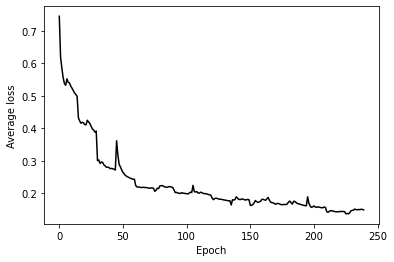

In [112]:
ax1 = sns.lineplot(x='index',
             y='avg_loss_list_by_iteration',
             data=results_metrics.reset_index(),
             color = "#000000"     )

ax1.set(xlabel='Epoch', ylabel='Average loss')
plt.show()

In [101]:
results_metrics

,avg_loss_list_by_iteration,F1_progression,Accuracy_progression,Precision_progression,Recall_progression
0,0.744432,0.190983,0.187590,0.545919,0.115736
1,0.618845,0.906235,0.828547,0.828547,1.000000
2,0.585292,0.905987,0.828133,0.828133,1.000000
3,0.556555,0.905958,0.828084,0.828084,1.000000
4,0.537592,0.906228,0.828534,0.828534,1.000000
...,...,...,...,...,...
235,0.150021,0.964145,0.938629,0.934140,0.996142
236,0.149506,0.969603,0.950732,0.991752,0.948421
237,0.150782,0.964811,0.939706,0.934289,0.997395
238,0.150322,0.965119,0.940343,0.935874,0.996251


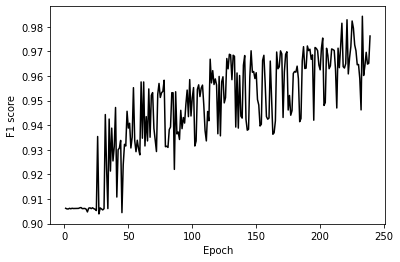

In [115]:
ax2 = sns.lineplot(x='index',
             y='F1_progression',
             data=results_metrics[1:].reset_index(),
             color = "#000000"     )

ax2.set(xlabel='Epoch', ylabel='F1 score')
plt.show()